# 6.338/18.337 Project
Harriet Li (kameeko@)

### Scientific Context

With technologies like additive manufacturing, laser cutting, and etching, there are a variety of applications for which one can design parts or devices of almost arbitrary shape. Topological optimization aims to find optimal designs that are free from the shape constraints previously imposed by the need to use simple components (ex: build a truss out of straight beams) or by manufacturing techniques (ex: if holes can only be made using drills); this allows the designer to trade irregularity of form for more efficient performance. 

Topological optimization is often performed by designating a space within which the design should fit and is allowed to change, and then deciding whether each point or subregion contains which of two materials (where one material may correspond to "no material"). Below is a result from designing a cantilever that's fixed on the left and loaded downwards on the right. The design region is a box between the fixed and loaded ends, and the black regions denote regions of structural material.

<img src="cantilever.png" alt="topological optimization cantilever (from http://1.bp.blogspot.com/-AIOAP646jHg/U8rexScJJ1I/AAAAAAAACeg/Wm7EYJZAjXU/s1600/cantilever.png)" style="width: 300px;"/>

One can also consider the uncertainty in the design process; for example, the materials may have a range of possible properties depending on the quality of the source material and the manufacturing process. In this case, one approach is to characterize the uncertainty by placing a distribution on it. Given this uncertainty, the value of the objective function for any given topology also becomes a distribution, which one can then map to a scalar through some chosen measure, such as the mean or variance of the distribution, or its distance from a target distribution. In either case, a closed-form solution for the objective function distribution is usually not available and samples must be used.

### Topological Optimization Problem (no uncertainties)

For this project, consider the problem of designing a device to best conduct heat, say, for the purpose of cooling electronic equipment. Consider a square plate with a heat sink on one side and constant heat source throughout:

<img src="problem_setup.png" alt="problem setup" style="width: 300px;"/>

Suppose one has a choice of two materials from which to make the device; one has a lower thermal conductivity but is "cheaper" (perhaps cheaper to purchase, or is less dense in a setting where weight matters), and the other has a higher thermal conductivity but is more expensive. One can solve a topological optimization problem to find a design composed of the two materials that best minimizes the temperature throughout the plate while minimizing its cost. One formulation of this topological optimization problem is given by
\begin{align}
\min_x && \frac{C_{MY}}{3}\left(\max\left(\int_\Omega (x-C_{VF})\ \textrm{d}\Omega,0\right)\right)^3+\frac{1}{100}\int_\Omega u\ \textrm{d}\Omega \\
\textrm{such that} && -\nabla \cdot (\sigma(x) \, \nabla u) = f, \\
&& u = 0\textrm{ on }\Gamma_{hs}, \\
&& \frac{\partial u}{\partial n}=0\textrm{ on }\partial\Omega\backslash\Gamma_{hs}, \\
&& \sigma(x) = \sigma_{min} + (\sigma_{max}-\sigma_{min})(3x^2-2x^3), \\
&& 0 \leq x \leq 1,
\end{align}
where optimization parameter $x$ denotes the presence ($x=1$) or absence ($x=0$) of the more expensive material (for which the thermal conductivity is $\sigma_{max}$). The heat sink is represented by the Dirichlet boundary condition at $\Gamma_{hs}$; the rest of the domain boundary has a homogeneous Neumann boundary condition. The objective function describes a balance between reducing the overall temperature $u$ and using less of the expensive material; the constant $C_{VF}$ describes a target volume fraction (portion of the domain in which the more expensive material is used), and the constant $C_{MY}$ can be increased to emphasize a smaller volume fraction over a lower overall temperature. This continuous formulation allows one to take advantage of a wider variety of optimization algorithms; the transformation $\sigma(x)$ encourages values of $x$ closer to the extremes of $0$ and $1$, and the final value of $x$ is post-processed via rounding to give a binary field denoting which material to use.

Different formulations of the topological optimization problem, particularly different choices of objective function and how strictly to enforce the desired volume fraction, will lead to different "optimal" topologies. A similar problem is solved in *Topology Optimization: Theory, Methods, and Applications* by Bendsoe and Sigmund (2003), and suggests that the optimal topology should resemble a tree rooted at the heat sink.

### Code

At the time of the proposal, there appeared to be no Julia package to do optimization where the uncertainty is characterized by a distribution. The `JuMPeR` package comes the closest, but only deals with uncertainty sets. There also appears to be no package targeted towards topological optimization. 

#### Attempt A

A first attempt was made using the `jInv` package, which is "a flexible framework for PDE parameter estimation" but supports custom, user-defined objective functions that consist of a "regularization" term (dependent on the parameter and not the state) and a "misfit" term (dependent on the state and not the parameters directly). It also supports additional parallelization when the forward system includes multiple mutually independent PDEs; although this parallelization was originally aimed towards cases like multiple-frequency systems, it should be amenable to each subsystem corrsponding to a different sample from the uncertainty distribution. The `DivSigGrad` package was used as a basis for the PDE constraint (modifications were required to described Dirichlet boundary conditions).

It appears that the `jInv` package has a very limited set of optimization solvers. They are tied to the assumption that the objective function has the previously mentioned "regularization" and "misfit" terms, and don't appear easy to swap out for other solvers. The included solvers performed very poorly for the topological optimization problem. The projected Gauss-Newton Conjugate Gradient (`projGNCG`) algorithm requires a full-rank Hessian for the regularization term, which this problem lacks. The projected steepest-descent (`projSD`) makes progress towards the optimum, but converges very slowly; for a 16 $\times$ 16 mesh, the parameter field $x$ does not at all resemble a tree after 13000 iterations.

<img src="sad_tree.png" alt="projSD solution" style="width: 300px;"/>

#### Attempt B

`JuMP` was considered as a possible next option, since it has access to a much wider variety of nonlinear solvers. However, the syntax for general nonlinear constraints and objective functions is much more constrained than that for linear and quadratic versions. The PDE constraint, whether expressed as a constraint or as part of the objective function, is difficult to express concisely, though much of the code could be generated programmatically (see https://github.com/JuliaOpt/JuMP.jl/issues/799).

#### Attempt C

The solver of immediate interest in `JuMP` was the `NLopt` solver, which is free/open-source and has its own Julia interface in the Julia package of the same name. The `NLopt` solver itself does not share the syntax constraints that `JuMP` has; the user need only provide the value and gradient for the objective function and any constraint functions. This is the approach presented here...

In [1]:
#install unregistered package (will complain if you already did this...)
#Pkg.clone("https://github.com/JuliaInv/jInv.jl","jInv")

In [2]:
Pkg.add("PyPlot")
Pkg.add("KrylovMethods")

#requires installation of NLopt library first (http://ab-initio.mit.edu/wiki/index.php/NLopt)
Pkg.add("NLopt") 

Pkg.update()

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of KrylovMethods
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of NLopt
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Updating METADATA...
INFO: Updating cache of DataFrames...
INFO: Updating cache of DataFrames...
INFO: Updating jInv master... 7f7132ec → 8ea04281
INFO: Updating DivSigGrad master...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [3]:
#add processors for sampling later, when considering uncertainty
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [4]:
#keep aspects of jInv that make defining PDE easier (mesh, iterative linear solver)
import jInv.Mesh
import jInv.Utils
import jInv.LinearSolvers
@everywhere begin
    using jInv.Mesh
    using jInv.Utils
    using jInv.LinearSolvers
end

In [5]:
@everywhere using KrylovMethods
@everywhere using PyPlot

Pkg.build("NLopt")
using NLopt

INFO: Building NLopt


Define the domain and boundary conditions, and constants $C_{VF}$ and $C_{MY}$:

In [6]:
@everywhere domain = [0.0 1.0 0.0 1.0]; #boundaries for the 2D domain
@everywhere n = [32 32]; #number of elements for each dimension
@everywhere mesh = getRegularMesh(domain,n);
mesh_plot = getRegularMesh(domain,n+1)
@everywhere dA = mesh.h[1]*mesh.h[1];

#Dirichlet BCs
@everywhere indl = div(n[1],2)+1-div(n[1],16);
@everywhere indr = div(n[1],2)+1+div(n[1],16);
@everywhere isDiri = collect(indl:indr);
@everywhere diriVal = zeros(size(collect(indl:indr)));

@everywhere cVF = 0.1;
cMY = 30.0;

Define functions to solve for state, objective function, and gradients:

In [7]:
#iterative linear solver
@everywhere PCGsolver(A,b;M=M,tol=1e-14,maxIter=200,out=-1) = 
    KrylovMethods.cg(A,b;M=M,tol=1e-14,maxIter=200,out=-1)
@everywhere A_inv = getIterativeSolver(PCGsolver)

In [8]:
@everywhere function getState(sigma::Vector{Float64})
    G = getNodalGradientMatrix(mesh)
    Ae = getEdgeAverageMatrix(mesh) 
    V = getVolume(mesh)
    A = (G'*sdiag(Ae'*V*vec(sigma)))*G
    
    for ii in isDiri
        A[ii,ii] += 1/mesh.h[1];
    end
    
    f = 1.e-4*ones(Float64,n[1]+1,n[2]+1); 
    f = vec(f[:]);
    f[isDiri] += diriVal/mesh.h[1]
        
    #u = A\f;
    A_inv.doClear=1
    u, = solveLinearSystem(A,f,A_inv)
    A_inv.doClear=0
    
    return u
end

In [9]:
@everywhere function getSensTMatVec( #(du/dsigma)' * v
    v::Vector{Float64},
    sigma::Vector{Float64},
    u::Vector{Float64})
    
    G = getNodalGradientMatrix(mesh)
    Ae = getEdgeAverageMatrix(mesh) 
    V = getVolume(mesh)
    A = (G'*sdiag(Ae'*V*vec(sigma)))*G
    
    for ii in isDiri
        A[ii,ii] += 1/mesh.h[1];
    end

    A_inv.doClear=1
    Zt,  = solveLinearSystem(A,v,A_inv)  
    A_inv.doClear=0
    JTv  = - V*Ae*((G*u).*(G*Zt))
    
    return vec(JTv)
end

In [10]:
@everywhere function paramToSigma(x::Vector{Float64}) #sigma(x)
    sigma_min = 1.0e-3;
    sigma_max = 1.0;
    
    sigma = sigma_min*ones(size(x)) +
                (sigma_max-sigma_min)*(3*x.^2 - 2*x.^3);
    dsigma = (sigma_max-sigma_min)*(6*x-6*x.*x);
    
    return sigma,spdiagm(dsigma)
end

In [11]:
function objfx(x::Vector{Float64}, grad::Vector{Float64})
    
    volPenalty = cMY*max((1/3)*(sum(x-cVF)*dA)^3,0);
    if(volPenalty > 0)
        dvolPen = cMY*((sum(x-cVF)*dA)^2)*dA*ones(size(x))
    else
        dvolPen = zeros(size(x))
    end
    
    sigma, dsigmadx = paramToSigma(x) 

    u = getState(sigma)
    
    #crude integral
    node_weights = ones(size(u))
    node_weights[:,1] = 0.5;
    node_weights[:,end] = 0.5;
    node_weights[1,:] = 0.5;
    node_weights[end,:] = 0.5;
    node_weights[1,1] = 0.25;
    node_weights[1,end] = 0.25;
    node_weights[end,1] = 0.25;
    node_weights[end,end] = 0.25;
    
    tempPenalty = 0.01*sum(vec(node_weights).*vec(u).*vec(u));
  
    fx = volPenalty + tempPenalty; #objective function value
    
    if length(grad) > 0 #set grad to gradient, in place
        dtempPen = dsigmadx'*getSensTMatVec(2*0.01*vec(node_weights).*vec(u),sigma,u)
        for ii = 1:length(grad)
            grad[ii] = dvolPen[ii] + dtempPen[ii]
        end
    end
    
    return fx
end

objfx (generic function with 1 method)

Let's see what the state looks like for uniform forcing and expensive material everywhere:

In [12]:
#forward test; uniform forcing and conductivity
tic()
u_test = getState(ones(prod(n)))
toc()

elapsed time: 2.922979731 seconds


2.922979731

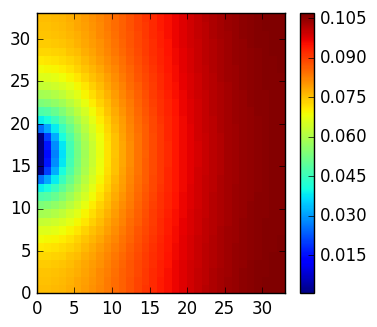

(0.0,33.0,0.0,33.0)

In [13]:
figure(figsize=[4,3.5])
pcolormesh(reshape(u_test,n[1]+1,n[2]+1))
colorbar()
axis("tight")

Define and solve the optimization problem, using the SLSQP (Sequential Least-Squares Quadratic Programming) algorithm:

In [14]:
opt = Opt(:LD_SLSQP, prod(n)); #solve using SLSQP algorithm on prodn(n) parameters

Opt(:LD_SLSQP, 1024)

In [15]:
min_objective!(opt, objfx) #objective function is to be minimized

#bounds on optimization paramters
lower_bounds!(opt, 0.0)
upper_bounds!(opt, 1.0)

In [16]:
#get compilation out of the way for timing
maxeval!(opt,2)
tic()
optimize(opt, rand(prod(n)))
toc()

elapsed time: 8.677414511 seconds


8.677414511

In [17]:
#set stopping criteria

maxIter = 1000;
maxeval!(opt, maxIter)

maxTime = 3600; #in seconds
maxtime!(opt, maxTime)

xtol = 1.0e-6
xtol_rel!(opt, xtol)

In [18]:
x = cVF*ones(prod(n)) #initial guess

tic()
(optfx,optx,return_code) = optimize(opt, x)
@show return_code
toc()

return_code = :MAXTIME_REACHED
elapsed time: 3605.605708386 seconds


3605.605708386

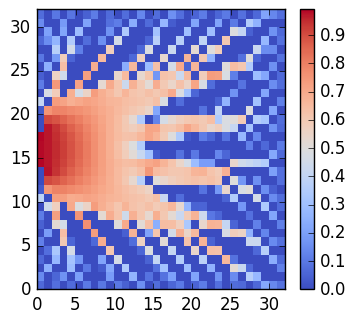

(0.0,32.0,0.0,32.0)

In [19]:
figure(figsize=[4,3.5])
pcolormesh(reshape(optx,n[1],n[2]),cmap=ColorMap("coolwarm"))
colorbar()
axis("tight")

Define and solve the optimization problem, using the MMA (Method of Moving Asymptotes) algorithm:

In [20]:
opt_mma = Opt(:LD_MMA, prod(n)); #solve using MMA algorithm on prodn(n) parameters

min_objective!(opt_mma, objfx)
lower_bounds!(opt_mma, 0.0)
upper_bounds!(opt_mma, 1.0)

In [21]:
#get compilation out of the way for timing
maxeval!(opt_mma,2)
tic()
optimize(opt_mma, rand(prod(n)))
toc()

elapsed time: 0.076654015 seconds


0.076654015

In [22]:
maxIter = 1000;
maxeval!(opt_mma, maxIter)

maxTime = 3600; #in seconds
maxtime!(opt_mma, maxTime)

xtol = 1.0e-7
xtol_rel!(opt_mma, xtol)

In [23]:
x = 0.5*ones(prod(n)) #initial guess
tic()
(optfx_mma,optx_mma,return_code_mma) = optimize(opt_mma, x)
@show return_code_mma
toc()

return_code_mma = :XTOL_REACHED
elapsed time: 16.958406988 seconds


16.958406988

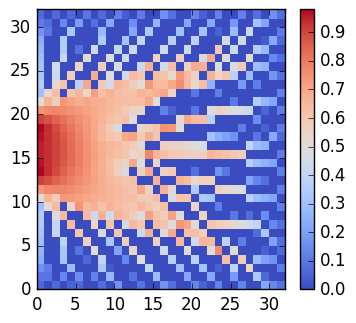

(0.0,32.0,0.0,32.0)

In [24]:
figure(figsize=[4,3.5])
pcolormesh(reshape(optx_mma,n[1],n[2]),cmap=ColorMap("coolwarm"))
colorbar()
axis("tight")

Let's see what happens when more importance is placed on not exceeding the target volume fraction by inceasing $C_{MY}$...

In [25]:
cMY = 50.0;
opt_mma_cmy50 = Opt(:LD_MMA, prod(n)); #solve using MMA algorithm on prodn(n) parameters

min_objective!(opt_mma_cmy50, objfx)
lower_bounds!(opt_mma_cmy50, 0.0)
upper_bounds!(opt_mma_cmy50, 1.0)

maxIter = 1000;
maxeval!(opt_mma_cmy50, maxIter)

maxTime = 3600; #in seconds
maxtime!(opt_mma_cmy50, maxTime)

xtol = 1.0e-7
xtol_rel!(opt_mma_cmy50, xtol)

In [26]:
x = 0.5*ones(prod(n)) #initial guess
tic()
(optfx_mma_cmy50,optx_mma_cmy50,return_code_mma_cmy50) = optimize(opt_mma_cmy50, x)
@show return_code_mma_cmy50
toc()

return_code_mma_cmy50 = :XTOL_REACHED
elapsed time: 22.241552143 seconds


22.241552143

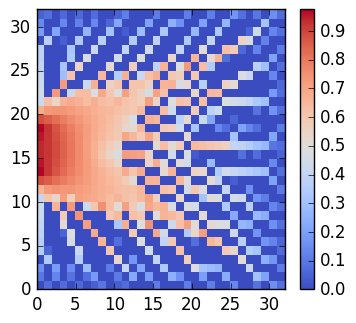

(0.0,32.0,0.0,32.0)

In [27]:
figure(figsize=[4,3.5])
pcolormesh(reshape(optx_mma_cmy50,n[1],n[2]),cmap=ColorMap("coolwarm"))
colorbar()
axis("tight")

...and even more emphasis on not exceeding target volume fraction?

In [28]:
cMY = 300.0;
opt_mma_cmy300 = Opt(:LD_MMA, prod(n)); #solve using MMA algorithm on prodn(n) parameters

min_objective!(opt_mma_cmy300, objfx)
lower_bounds!(opt_mma_cmy300, 0.0)
upper_bounds!(opt_mma_cmy300, 1.0)

maxIter = 1000;
maxeval!(opt_mma_cmy300, maxIter)

maxTime = 3600; #in seconds
maxtime!(opt_mma_cmy300, maxTime)

xtol = 1.0e-8
xtol_rel!(opt_mma_cmy300, xtol)

In [29]:
x = 0.5*ones(prod(n)) #initial guess
tic()
(optfx_mma_cmy300,optx_mma_cmy300,return_code_mma_cmy300) = optimize(opt_mma_cmy300, x)
@show return_code_mma_cmy300
toc()

return_code_mma_cmy300 = :XTOL_REACHED
elapsed time: 21.469133422 seconds


21.469133422

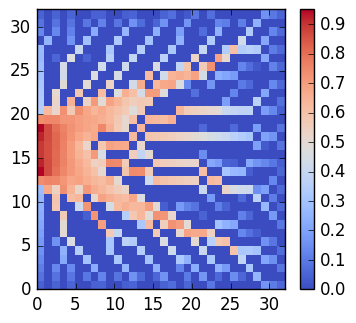

(0.0,32.0,0.0,32.0)

In [30]:
figure(figsize=[4,3.5])
pcolormesh(reshape(optx_mma_cmy300,n[1],n[2]),cmap=ColorMap("coolwarm"))
colorbar()
axis("tight")

Post-process by rounding:

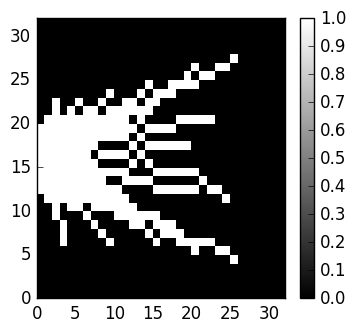

(0.0,32.0,0.0,32.0)

In [31]:
figure(figsize=[4,3.5])
pcolormesh(reshape(round(optx_mma_cmy300),n[1],n[2]),cmap=ColorMap("gray"))
colorbar()
axis("tight")

Although the problem is symmetric and thus one expects the optimal parameter field to be symmetric, this was not enforced in the optimization problem. One can post-process to get a symmetric field: 

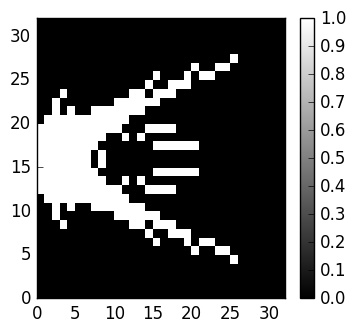

(0.0,32.0,0.0,32.0)

In [32]:
#average two sides to get symmetry
figure(figsize=[4,3.5])
pcolormesh(round(0.5*(reshape(optx_mma_cmy300,n[1],n[2])+flipdim(reshape(optx_mma_cmy300,n[1],n[2]),1))),cmap=ColorMap("gray"))
colorbar()
axis("tight")

What does the state look like with this post-processed, symmetric material field?

In [33]:
#plot state with post-processed parameters
x_pp = vec(round(0.5*(reshape(optx_mma_cmy300,n[1],n[2])+flipdim(reshape(optx_mma_cmy300,n[1],n[2]),1))));
sigma_pp, = paramToSigma(x_pp);
u_pp = getState(sigma_pp);

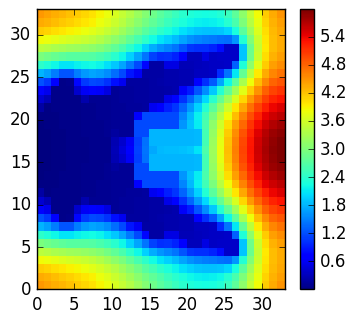

(0.0,33.0,0.0,33.0)

In [34]:
figure(figsize=[4,3.5])
pcolormesh(reshape(u_pp,n[1]+1,n[2]+1))
colorbar()
axis("tight")

### Topological Optimization Problem (one uncertainty)

Let's consider consider uncertainty in the thermal conductivity of the cheaper material ($\sigma_{min}$). Suppose the uncertainty takes the form of a uniform distribution.

With this uncertainty, for every value of the optimization parameters, the objective function $q(x)$ becomes a distribution $Q(x)$. One way to deal with this is to define a new objective function that corresponds to a distance between the current cumulative distribution function (CDF) and a target CDF (which need not be feasible), an approach called "horsetail matching", described in  *Horsetail Matching: A Flexible Approach to Optimization Under Uncertainty* (Cook, L & Jarrett, J., submitted to Journal of Engineering Optimization, 2016). The main idea behind this approach is to find a design that is *robustly inferior* to no other; supposing $Q(x)$ represents a quantity to be minimized, a design $x$ is robustly inferior to a design $x^*$ if 
$\mathbb{P}(Q(x^*)\leq a) > \mathbb{P}(Q(x)\leq a)$, 
for any $a$. In the image below, the red design is robustly inferior to the green design.

<img src="horsetail.png" alt="horsetails" style="width: 300px;"/>

For this problem, the state and the volume fraction penalty term are always non-negative; the target CDF is an impossible step function at zero.

In [35]:
@everywhere cMY = 300.0;

Define versions of previous functions that take samples of $\sigma_{min}$:

In [36]:
@everywhere function paramToSigma_ht(x::Vector{Float64}, sigma_min::Float64)
    #sigma_min = 1.0e-3;
    sigma_max = 1.0;
    
    sigma = sigma_min*ones(size(x)) +
                (sigma_max-sigma_min)*(3*x.^2 - 2*x.^3);
    dsigma = (sigma_max-sigma_min)*(6*x-6*x.*x);
    
    return sigma,spdiagm(dsigma)
end

In [37]:
@everywhere function objfx_sigma(x::Vector{Float64}, grad::Vector{Float64}, sigma_min::Float64)
    
    volPenalty = cMY*max((1/3)*(sum(x-cVF)*dA)^3,0);
    if(volPenalty > 0)
        dvolPen = cMY*((sum(x-cVF)*dA)^2)*dA*ones(size(x))
    else
        dvolPen = zeros(size(x))
    end
    
    sigma, dsigmadx = paramToSigma_ht(x, sigma_min) 

    u = getState(sigma)
    
    #crude integral
    node_weights = ones(size(u))
    node_weights[:,1] = 0.5;
    node_weights[:,end] = 0.5;
    node_weights[1,:] = 0.5;
    node_weights[end,:] = 0.5;
    node_weights[1,1] = 0.25;
    node_weights[1,end] = 0.25;
    node_weights[end,1] = 0.25;
    node_weights[end,end] = 0.25;
    
    tempPenalty = 0.01*sum(vec(node_weights).*vec(u).*vec(u));
    
    fx = volPenalty + tempPenalty; #obj fx value

    if length(grad) > 0 #set grad to gradient, in place
        dtempPen = dsigmadx'*getSensTMatVec(2*0.01*vec(node_weights).*vec(u),sigma,u)
        for ii = 1:length(grad)
            grad[ii] = dvolPen[ii] + dtempPen[ii]
        end
    end
    
    return fx
end

To integrate between the current and target CDFs, the current CDF is approximated using kernel density estimation (KDE) with a Gaussian kernel:

In [38]:
function sampleCDF(
    x::Vector{Float64},
    N::Int64, #number of CDF samples
    M::Int64, #number of kernels to approximate CDF with
    sample_objfx::Function, 
    dhqdx::Array{Float64},
    bandwidth::Float64)
    
    if(size(dhqdx,1) == N && size(dhqdx,2) == length(x))
        objfx_grad_samples = SharedArray(Float64,M,length(x));
        objfx_samples_quad = sort!(sample_objfx(x,N,SharedArray(Float64,0))); #for quadrature
        objfx_samples = sample_objfx(x,M,objfx_grad_samples); #for building CDF approximation
    else
        objfx_samples_quad = sort!(sample_objfx(x,N,SharedArray(Float64,0))); #for quadrature
        objfx_samples = sample_objfx(x,M,SharedArray(Float64,0)); #for building CDF approximation
    end
    
    
    #approximate CDF at quadrature samples, Gaussian kernel approximation
    hq = (1/M)*sum(0.5*(1+erf((repmat(objfx_samples_quad,1,M)-repmat(objfx_samples',N,1))/sqrt(2*bandwidth^2))),2);
    if(size(dhqdx,1) == N && size(dhqdx,2) == length(x))
        for kk = 1:length(x)
            dhqdx[:,kk] = -(1/M)*(1/sqrt(2*pi*bandwidth^2))*
            exp(-(1/2)*((repmat(objfx_samples_quad,1,M)-repmat(objfx_samples',N,1))/bandwidth).^2)*objfx_grad_samples[:,kk]
        end
    end
    
    return objfx_samples_quad, hq
end

sampleCDF (generic function with 1 method)

Define new objective function corresponding to distance between target and current CDFs:

In [39]:
function objfx_ht_Dhat(
    x::Vector{Float64}, 
    grad::Vector{Float64}, 
    sample_objfx::Function, 
    bandwidth::Float64,
    objfx_stash::Vector{Float64})
    
    M = 2000; #number of samples to build Gaussian kernel approximation of CDF
    N = 1000; #number of quadrature points
    
    if length(grad) > 0
        dhqdx = zeros(N,length(x));
    else
        dhqdx = Float64[];
    end

    objfx_samples_quad, hq = sampleCDF(x,N,M,sample_objfx,dhqdx,bandwidth)
    
    #quadrature weights
    hq_aug = [hq[1]; hq; hq[end]];
    W = spdiagm(0.5*(hq_aug[3:end]-hq_aug[1:end-2]));

    fx = (objfx_samples_quad'*W*objfx_samples_quad)[1];

    if length(grad) > 0 
        #gradient of quadrature weights
        dhqdx_aug = [dhqdx[1,:]'; dhqdx; dhqdx[end,:]'];
        dWdiagdx = 0.5*(dhqdx_aug[3:end,:]-dhqdx_aug[1:end-2,:]);
        
        #set grad to gradient, in place
        for kk = 1:length(grad)
            grad[kk] = (objfx_samples_quad'*spdiagm(dWdiagdx[:,kk])*objfx_samples_quad)[1];
        end
    end
    
    push!(objfx_stash,fx)

    return fx
end

objfx_ht_Dhat (generic function with 1 method)

To avoid having to generate many samples of the (relatively) expensive objective function $q(x)$, one can build a surrogate model of the distribution $Q(x)$ as a function of the uncertainty, at each $x$ encountered in the optimization process and generate samples from there. A polynomal response surface is used here.

In [40]:
function sample_objfx_poly_resp_surf(
    x::Vector{Float64}, 
    M::Int64, 
    grad_samps::SharedArray{Float64})
    
    k = 3; #order of polynomial fit 
    a = 1.0e-4; #left boundary of uniform uncertainty
    b = 1.0e-2; #right boundary of uniform uncertainty
    
    #samples from which to build response surface
    M_build = 10*k;
    #sigma_min_samps = (b-a)*rand(M_build)+a; #Monte Carlo samples
    sigma_min_samps = linspace(a,b,M_build); #deterministic samples
    objfx_build_samps = SharedArray(Float64,M_build)
    if(size(grad_samps,1) == M && size(grad_samps,2) == length(x))
        grad_build_samps = SharedArray(Float64,M_build,length(x));
        @sync @parallel for ii = 1:M_build
            grad_samp = zeros(length(x));
            fx_samp = objfx_sigma(x,grad_samp,sigma_min_samps[ii]);
            objfx_build_samps[ii] = fx_samp;
            grad_build_samps[ii,:] = grad_samp;
        end
    else
        @sync @parallel for ii = 1:M_build
            fx_samp = objfx_sigma(x,Float64[],sigma_min_samps[ii]);
            objfx_build_samps[ii] = fx_samp;
        end
    end
    
    
    #get coefficients of polynomial response surface
    Arb = zeros(M_build,k+1);
    for kk = 1:k+1
        Arb[:,kk] = sigma_min_samps.^(kk-1);
    end
    objfx_coeffs = Arb\objfx_build_samps;
    if(size(grad_samps,1) == M && size(grad_samps,2) == length(x))
        grad_coeffs = zeros(length(x),k+1)
        for ii = 1:length(x)
            grad_coeffs[ii,:] = Arb\grad_build_samps[:,ii];
        end
    end
    
    #sample from response surface
    #sigma_min_samps = (b-a)*rand(M)+a; #Monte Carlo samples
    sigma_min_samps = linspace(a,b,M); #deterministic samples
    Ar = zeros(M,k+1)
    for kk = 1:k+1
        Ar[:,kk] = sigma_min_samps.^(kk-1);
    end
    objfx_samps = Ar*objfx_coeffs;
    if(size(grad_samps,1) == M && size(grad_samps,2) == length(x))
        for ii = 1:length(x)
            grad_samps[:,ii] = Ar*grad_coeffs[ii,:] 
        end
    end
    
    return objfx_samps
end

sample_objfx_poly_resp_surf (generic function with 1 method)

Also define direct sampling, for comparison with the response surface:

In [41]:
function sample_objfx(
    x::Vector{Float64}, 
    M::Int64, 
    grad_samps::SharedArray{Float64}) #direct sampling of objfx

    a = 1.0e-4; #left boundary of uniform uncertainty
    b = 1.0e-2; #right boundary of uniform uncertainty
    
    #direct sampling
    #sigma_min_samps = (b-a)*rand(M)+a; #Monte Carlo samples
    sigma_min_samps = linspace(a,b,M); #deterministic samples
    objfx_samps = SharedArray(Float64,M)
    if(size(grad_samps,1) == M && size(grad_samps,2) == length(x))
        grad_samp = zeros(length(x));
        @sync @parallel for ii = 1:M
            fx_samp = objfx_sigma(x,grad_samp,sigma_min_samps[ii]);
            objfx_samps[ii] = fx_samp;
            grad_samps[ii,:] = grad_samp;
        end
    else
        grad_samp = Float64[];
        @sync @parallel for ii = 1:M
            fx_samp = objfx_sigma(x,grad_samp,sigma_min_samps[ii]);
            objfx_samps[ii] = fx_samp;
        end
    end
    
    return objfx_samps
end

sample_objfx (generic function with 1 method)

In [42]:
x = 0.5*ones(prod(n)); #initial guess;

In [43]:
#get compile timing out of way
tic()
sample_objfx_poly_resp_surf(x,3,SharedArray(Float64,0))
sample_objfx(x,3,SharedArray(Float64,0))
toc()

elapsed time: 9.945280058 seconds


9.945280058

Compare samples from response surface and direct samples:

In [44]:
#compare response surface samples and direct samples
n_hist_samples = 2000;
tic()
poly_samples = sample_objfx_poly_resp_surf(x,n_hist_samples,SharedArray(Float64,0))
toc()
tic()
direct_samples = sample_objfx(x,n_hist_samples,SharedArray(Float64,0))
toc()

elapsed time: 0.269313562 seconds
elapsed time: 9.337003491 seconds


9.337003491

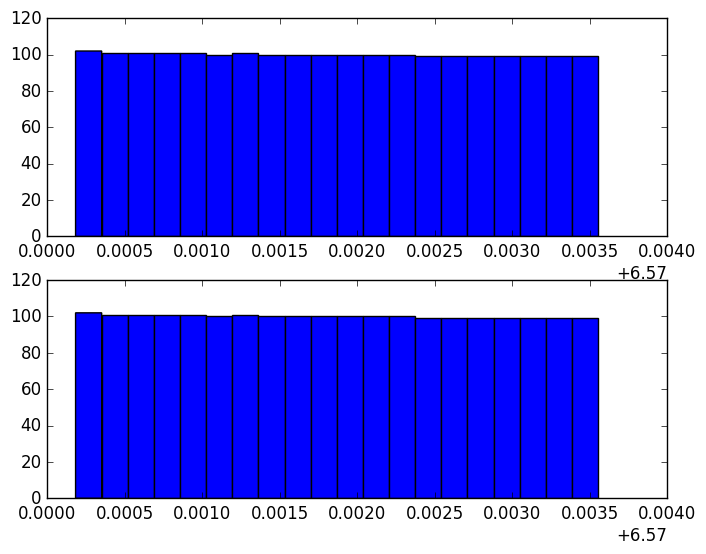

In [45]:
figure()
ax = subplot(211)
ax[:hist](poly_samples,20);
ax = subplot(212)
ax[:hist](direct_samples,20);

The Gaussian kernel requires a bandwidth, estimated here at the initial guess using Silverman's/Scott's rule:

In [46]:
#calculate a bandwidth for kernel approximation (using Silverman's/Scott's rule)
n_bw_samps = 100;
bw_samps = sample_objfx(x,n_bw_samps,SharedArray(Float64,0));
bandwidth = std(bw_samps)*((4/3)/n_bw_samps)^(1/5);

Compare empirical and KDE-approximated CDFs:

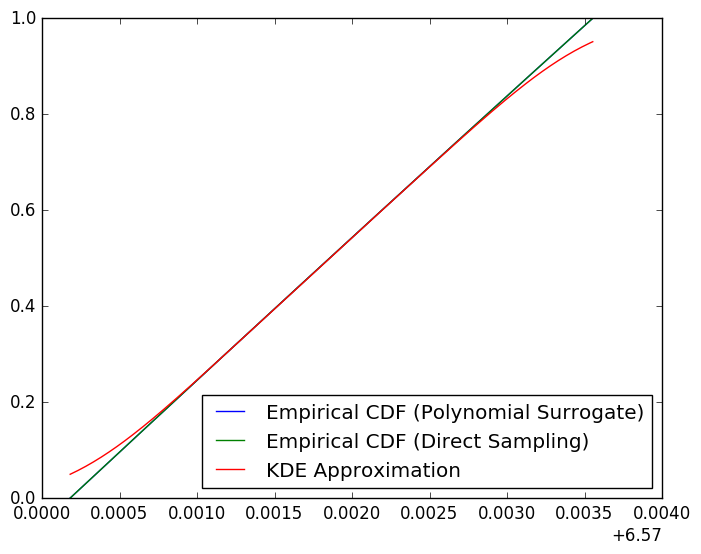

PyObject <matplotlib.legend.Legend object at 0x7fb3d10e3c10>

In [47]:
plot(sort!(poly_samples),collect(1:length(poly_samples))/length(poly_samples))
plot(sort!(direct_samples),collect(1:length(direct_samples))/length(direct_samples))

q, hq = sampleCDF(x,200,n_hist_samples,sample_objfx_poly_resp_surf,Float64[],bandwidth)
plot(q,hq)
legend(["Empirical CDF (Polynomial Surrogate)","Empirical CDF (Direct Sampling)","KDE Approximation"],loc="best")

Try solving the horsetail-matching problem using MMA:

In [48]:
objfx_stash = Float64[];
objfx_ht(x::Vector{Float64}, grad::Vector{Float64}) = 
    objfx_ht_Dhat(x::Vector{Float64}, grad::Vector{Float64}, sample_objfx_poly_resp_surf, bandwidth, objfx_stash)

  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /home/kameeko/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /home/kameeko/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /home/kameeko/.julia/v0.5/PyCall/sr

objfx_ht (generic function with 1 method)

In [49]:
@everywhere cMY = 300.0;
opt_mma_ht_cmy300 = Opt(:LD_MMA, prod(n)); #solve using MMA algorithm on prodn(n) parameters

min_objective!(opt_mma_ht_cmy300, objfx_ht)
lower_bounds!(opt_mma_ht_cmy300, 0.0)
upper_bounds!(opt_mma_ht_cmy300, 1.0)

maxIter = 200;
maxeval!(opt_mma_ht_cmy300, maxIter)

maxTime = 2*3600; #in seconds
maxtime!(opt_mma_ht_cmy300, maxTime)

xtol = 1.0e-8
xtol_rel!(opt_mma_ht_cmy300, xtol)

In [50]:
tic()
(optfx_mma_ht_cmy300,optx_mma_ht_cmy300,return_code_mma_ht_cmy300) = optimize(opt_mma_ht_cmy300, x)
@show return_code_mma_ht_cmy300
toc()

return_code_mma_ht_cmy300 = :MAXTIME_REACHED
elapsed time: 7200.38611951 seconds


7200.38611951

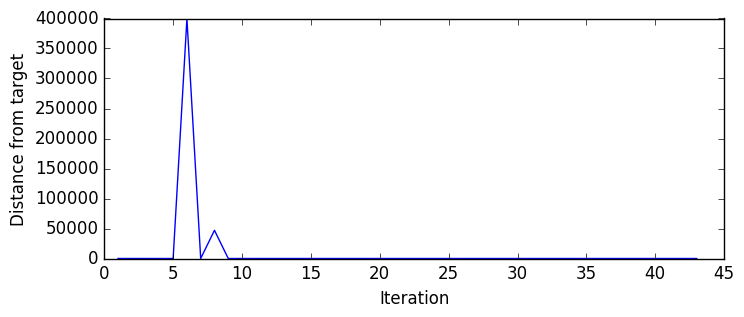

PyObject <matplotlib.text.Text object at 0x7fb3ce2eac90>

In [51]:
figure(figsize=[8,3])
plot(collect(1:length(objfx_stash)),objfx_stash)
ylabel("Distance from target")
xlabel("Iteration")

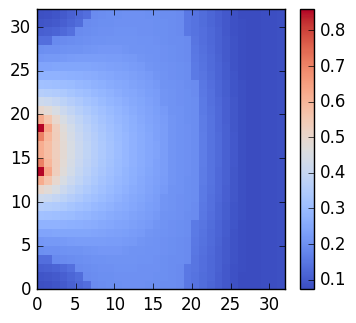

(0.0,32.0,0.0,32.0)

In [52]:
figure(figsize=[4,3.5])
pcolormesh(reshape(optx_mma_ht_cmy300,n[1],n[2]),cmap=ColorMap("coolwarm"))
colorbar()
axis("tight")

This has definitely not finished solving (cut off due to kernel dying, for no given reason...), since the CDFs clearly indicate robust inferiority relative to the optimal solution in the no-uncertainty case, although much progress has been made since the initial guess, so perhaps the MMA algoritm is not quite so quick when this approach to dealing with this uncertainty is used:

In [53]:
#plot objfx CDFs at various "optimal" solutions
n_hist_samples = 2000;
poly_samples_det = sample_objfx_poly_resp_surf(optx_mma_cmy300,n_hist_samples,SharedArray(Float64,0));
poly_samples_ht_mma = sample_objfx_poly_resp_surf(optx_mma_ht_cmy300,n_hist_samples,SharedArray(Float64,0));
poly_samples_init = sample_objfx_poly_resp_surf(x,n_hist_samples,SharedArray(Float64,0));

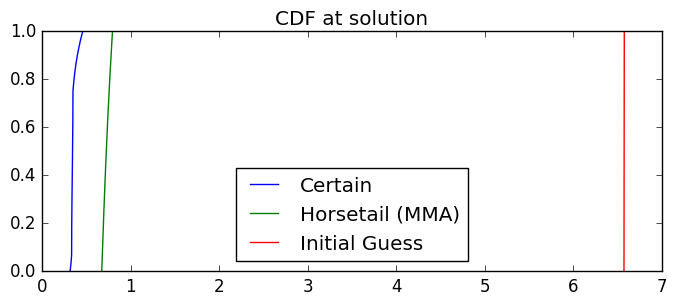

PyObject <matplotlib.text.Text object at 0x7fb3ccd30b50>

In [54]:
figure(figsize=[8,3])
plot(sort!(poly_samples_det),collect(1:n_hist_samples)/n_hist_samples)
plot(sort!(poly_samples_ht_mma),collect(1:n_hist_samples)/n_hist_samples)
plot(sort!(poly_samples_init),collect(1:n_hist_samples)/n_hist_samples)
legend(["Certain","Horsetail (MMA)","Initial Guess"],loc="best")
title("CDF at solution")

This approach to robust optimization has not been previously applied to topological optmization, so it is unclear whether the convergence difficulties are due to a bug in the code or a need for a different optimization algorithm...